In [ ]:
import tensorflow as tf

# Get the GPU device name.
device_name = tf.test.gpu_device_name()

# The device name should look like the following:
if device_name == '/device:GPU:0':
    print('Found GPU at: {}'.format(device_name))
else:
    raise SystemError('GPU device not found')

Found GPU at: /device:GPU:0


In [ ]:
import torch

# If there's a GPU available...
if torch.cuda.is_available():    

    # Tell PyTorch to use the GPU.    
    device = torch.device("cuda")

    print('There are %d GPU(s) available.' % torch.cuda.device_count())

    print('We will use the GPU :', torch.cuda.get_device_name(0))

# If not...
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
We will use the GPU: Tesla P100-PCIE-16GB


In [ ]:
#It will Install the transformor module from Hugging Face library
!pip install transformers


In [ ]:
import pandas as pd

#loading the dataset
df = pd.read_csv("/content/drive/My Drive/MinorProject/eng_train.csv")

#removing unnecessary columns
df=df.drop(columns=['ID','Sub-task A'])


print('Number of training sentences: {:,}\n'.format(df.shape[0]))


df.sample(10)

Number of training sentences: 4,263



,Text,Sub-task B
3883,great show,NGEN
2439,There just problem with the movie and where I ...,NGEN
1786,Rohit barman nice,NGEN
2329,Totally agreed with your practicality but ther...,NGEN
2567,From today onward she will be called kungfu bitc?,NGEN
3534,very good,NGEN
1572,<https://youtu.be/ghDIOlPnaA4>,NGEN
1393,Very true ! And best analysis covering all thi...,NGEN
1830,I want to ask Singer like Sona Mohapatra But t...,NGEN
2339,Koyel Di rite and very nice,NGEN


In [ ]:
# there is two task as GEN (basically means hate speech) and NGEN (basically means not hate speech). 

#mapping into intergers
df['Sub-task B'] = df['Sub-task B'].map({'GEN': 0, 'NGEN':1})
df.head()

,Text,Sub-task B
0,Next part,1
1,Iii8mllllllm\nMdxfvb8o90lplppi0005,1
2,🤣🤣😂😂🤣🤣🤣😂osm vedio ....keep it up...make more v...,1
3,What the fuck was this? I respect shwetabh and...,1
4,Concerned authorities should bring arundathi R...,1


In [ ]:
df=df.rename(columns={"Sub-task B":"label"})

In [ ]:
sentences = df.Text.values
labels = df.label.values

In [ ]:
sentences

array(['Next part', 'Iii8mllllllm\nMdxfvb8o90lplppi0005',
       '🤣🤣😂😂🤣🤣🤣😂osm vedio ....keep it up...make more vedios like this',
       ...,
       'People may criticize Pratik Borade by saying that he takes movies too\nseriously and always talks about ideologies instead of focusing on technical\naspects. But ideology IS the most important thing. People in India are\ninfluenced by movies more than anything else. So if a movie is trying to\npromote negativity in society subliminally or openly it needs to be called out\nand criticised openly. Some will say "Oh it is just a film." But many people\nDO take these movies seriously and it does affect as well as change their\nlives. So though I disagree with Pratik regarding some movies, I hugely\nrespect what he does. Filmmakers should not be allowed to create whatever\nbullshit they want to manipulate minds of youths, simply in the name of\nartistic freedom!',
       '@Naaz Sk hello',
       'We want to read your book sir, please make it av

In [ ]:
labels

array([1, 1, 1, ..., 1, 1, 1])

In [ ]:
from transformers import BertTokenizer
# Load the BERT tokenizer.


# BERTBASE (768  12 )and BERTLARGE(1024 16) two types of bert model 
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

In [ ]:
# Tokenize all of the sentences and map the tokens to thier word IDs.
input_ids = []

# For every sentence...
for sent in sentences:
    # `encode` will:
    #   (1) Tokenize the sentence.
    #   (2) Prepend the `[CLS]` token to the start.
    #   (3) Append the `[SEP]` token to the end.
    #   (4) Map tokens to their IDs.
    encoded_sent = tokenizer.encode(
                        sent,  # Sentence to encode.
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                   )
    
    # Add the encoded sentence to the list.
    input_ids.append(encoded_sent)

Token indices sequence length is longer than the specified maximum sequence length for this model (676 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (997 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (812 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (606 > 512). Running this sequence through the model will result in indexing errors


In [ ]:
print('Max sentence length: ', max([len(sen) for sen in input_ids]))

Max sentence length:  999


In [ ]:
#padding the words in sentences , because in bert there is two conditions
#1)All sentences must be padded or truncated to a single, fixed length.
#2)The maximum sentence length is 512 tokens.


from keras.preprocessing.sequence import pad_sequences
MAX_LEN = 100


# Pad our input tokens with value 0.
# "post" indicates that we want to pad and truncate at the end of the sequence,
# as opposed to the beginning.

input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, dtype="long", 
                          value=0, truncating="post", padding="post")

In [ ]:
#The attention mask simply makes it explicit which tokens are actual words versus which are padding.

#The BERT vocabulary does not use the ID 0, so if a token ID is 0, then it's padding, and otherwise it's a real token.


attention_masks = []
for sent in input_ids:
    # Create the attention mask.
    #   - If a token ID is 0, then it's padding, set the mask to 0.
    #   - If a token ID is > 0, then it's a real token, set the mask to 1
    att_mask = [int(token_id > 0) for token_id in sent]
    attention_masks.append(att_mask)

In [ ]:
from sklearn.model_selection import train_test_split

# Use 90% for training and 10% for validation.
train_inputs, validation_inputs, train_labels, validation_labels = train_test_split(input_ids, labels, 
                                                            random_state=42, test_size=0.1)

# Do the same for the masks.
train_masks, validation_masks, _, _ = train_test_split(attention_masks, labels,
                                             random_state=42, test_size=0.1)

In [ ]:
# Convert all inputs and labels into torch tensors, the required datatype 
# for our model.
train_inputs = torch.tensor(train_inputs)
validation_inputs = torch.tensor(validation_inputs)

train_labels = torch.tensor(train_labels)
validation_labels = torch.tensor(validation_labels)

train_masks = torch.tensor(train_masks)
validation_masks = torch.tensor(validation_masks)

In [ ]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

# The DataLoader needs to know our batch size for training, so we specify it 
# here.
# For fine-tuning BERT on a specific task, it is  recommended for a batch size of
# 16 or 32.


batch_size = 32

# Create the DataLoader for our training set.
train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)


# Create the DataLoader for our validation set.
validation_data = TensorDataset(validation_inputs, validation_masks, validation_labels)
validation_sampler = SequentialSampler(validation_data)
validation_dataloader = DataLoader(validation_data, sampler=validation_sampler, batch_size=batch_size)


In [ ]:
from transformers import BertForSequenceClassification, AdamW, BertConfig

# Load BertForSequenceClassification, the pretrained BERT model with a single 
# linear classification layer on top. 
model = BertForSequenceClassification.from_pretrained(
    "bert-base-uncased", #Use the 12-layer BERT model, with an uncased vocab.
    num_labels = 2, # The number of output labels--2 for binary classification.
                    # You can increase this for multi-class tasks.    
    output_attentions = False,  # Whether the model returns attentions weights.
    output_hidden_states = False, # Whether the model returns all hidden-states.
)
model.cuda()

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

In [ ]:
params = list(model.named_parameters())
print('The BERT model has {:} different named parameters.\n'.format(len(params)))


print('==== Embedding Layer ====\n')
for p in params[0:5]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== First Transformer ====\n')
for p in params[5:21]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== Output Layer ====\n')
for p in params[-4:]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

The BERT model has 201 different named parameters.

==== Embedding Layer ====

bert.embeddings.word_embeddings.weight                  (30522, 768)
bert.embeddings.position_embeddings.weight                (512, 768)
bert.embeddings.token_type_embeddings.weight                (2, 768)
bert.embeddings.LayerNorm.weight                              (768,)
bert.embeddings.LayerNorm.bias                                (768,)

==== First Transformer ====

bert.encoder.layer.0.attention.self.query.weight          (768, 768)
bert.encoder.layer.0.attention.self.query.bias                (768,)
bert.encoder.layer.0.attention.self.key.weight            (768, 768)
bert.encoder.layer.0.attention.self.key.bias                  (768,)
bert.encoder.layer.0.attention.self.value.weight          (768, 768)
bert.encoder.layer.0.attention.self.value.bias                (768,)
bert.encoder.layer.0.attention.output.dense.weight        (768, 768)
bert.encoder.layer.0.attention.output.dense.bias              (

In [2]:
## Note: AdamW is a class from the huggingface library (as opposed to pytorch) 
#It is the object which changes weights in BERT MODEL , it has reference to the pytorch vectors
optimizer = AdamW(model.parameters(),
                  lr = 2e-5,   ## args.learning_rate - default is 5e-5, our notebook had 2e-5
                  eps = 1e-8   #args.adam_epsilon  - default is 1e-8.
                )


NameError: ignored

In [ ]:
from transformers import get_linear_schedule_with_warmup

# Number of training epochs (authors recommend between 2 and 4)
epochs = 4

# Total number of training steps is number of batches * number of epochs.
total_steps = len(train_dataloader) * epochs


# Create the learning rate scheduler. , it will decay the learning rate first very fastly then slowly
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0,
                                            num_training_steps = total_steps)

In [ ]:
import numpy as np


# Function to calculate the accuracy of our predictions vs labels
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

In [ ]:
import time
import datetime

def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))

    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))

In [ ]:
import random

# Set the seed value all over the place to make this reproducible.
seed_val = 42
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

# Storing the average loss after each epoch so we can plot them.

loss_values = []
for epoch_i in range(0, epochs):
    # ========================================
    #               Training
    # ========================================
    
    # Perform one full pass over the training set.
    
    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    # Measure how long the training epoch takes.
    t0 = time.time()


    # Reset the total loss for this epoch.
    total_loss = 0

    # Put the model into training mode. Don't be mislead--the call to 
    # `train` just changes the *mode*, it doesn't *perform* the training.
    # `dropout` and `batchnorm` layers behave differently during training
    model.train()


    # For each batch of training data...
    for step, batch in enumerate(train_dataloader):
        # Progress update every 40 batches.
        if step % 40 == 0 and not step == 0:
            # Calculate elapsed time in minutes.
            elapsed = format_time(time.time() - t0)
            # Report progress.
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))





    # Unpack this training batch from our dataloader. 
    #
    # As we unpack the batch, we'll also copy each tensor to the GPU using the 
    # `to` method.
    #
    # `batch` contains three pytorch tensors:
    #   [0]: input ids 
    #   [1]: attention masks
    #   [2]: labels 
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)



    # Always clear any previously calculated gradients before performing a
    # backward pass. PyTorch doesn't do this automatically because 
    # accumulating the gradients is "convenient while training RNNs"

        model.zero_grad()


    # Perform a forward pass (evaluate the model on this training batch).
    # This will return the loss (rather than the model output) because we
    # have provided the `labels`.
        outputs = model(b_input_ids, 
                    token_type_ids=None, 
                    attention_mask=b_input_mask, 
                    labels=b_labels)
        

    # The call to `model` always returns a tuple, so we need to pull the 
    # loss value out of the tuple.
        loss = outputs[0]


    # Accumulate the training loss over all of the batches so that we can
    # calculate the average loss at the end. `loss` is a Tensor containing a
    # single value; the `.item()` function just returns the Python value 
    # from the tensor.
        total_loss += loss.item()


    # Perform a backward pass to calculate the gradients.
        loss.backward()

    # Clip the norm of the gradients to 1.0.
    # This is to help prevent the "exploding gradients" problem.
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
 
    # Update parameters and take a step using the computed gradient.
    # The optimizer dictates the "update rule"--how the parameters are
    # modified based on their gradients, the learning rate, etc.
 
        optimizer.step()


    # Update the learning rate.
        scheduler.step()
   
   
    # Calculate the average loss over the training data.
    avg_train_loss = total_loss / len(train_dataloader)

    # Store the loss value for plotting the learning curve.            
    loss_values.append(avg_train_loss)

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epcoh took: {:}".format(format_time(time.time() - t0)))

    # ========================================
    #               Validation
    # ========================================
    # After the completion of each training epoch, measure our performance on
    # our validation set.

    
    print("")
    print("Running Validation...")
    t0 = time.time()


    # Put the model in evaluation mode--the dropout layers behave differently
    # during evaluation.
    model.eval()


    # Tracking variables
    eval_loss, eval_accuracy = 0, 0
    nb_eval_steps, nb_eval_examples = 0, 0


    # Evaluate data for one epoch
    for batch in validation_dataloader:
        # Add batch to GPU
        batch = tuple(t.to(device) for t in batch)

        # Unpack the inputs from our dataloader
        b_input_ids, b_input_mask, b_labels = batch


        # Telling the model not to compute or store gradients, saving memory and
        # speeding up validation
        with torch.no_grad():
            outputs = model(b_input_ids, 
                            token_type_ids=None, 
                            attention_mask=b_input_mask)
            

        # Forward pass, calculate logit predictions.
            # This will return the logits rather than the loss because we have
            # not provided labels.
            # token_type_ids is the same as the "segment ids", which 
            # differentiates sentence 1 and 2 in 2-sentence tasks.
            # The documentation for this `model` function is here: 




        # Get the "logits" output by the model. The "logits" are the output
        # values prior to applying an activation function like the softmax.
        logits = outputs[0]

        # Move logits and labels to CPU
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()


        # Calculate the accuracy for this batch of test sentences.
        tmp_eval_accuracy = flat_accuracy(logits, label_ids)


        # Accumulate the total accuracy.
        eval_accuracy += tmp_eval_accuracy

        # Track the number of batches
        nb_eval_steps += 1


    # Report the final accuracy for this validation run.
    print("  Accuracy: {0:.2f}".format(eval_accuracy/nb_eval_steps))
    print("  Validation took: {:}".format(format_time(time.time() - t0)))


======== Epoch 1 / 4 ========
Training...
  Batch    40  of    120.    Elapsed: 0:00:13.
  Batch    80  of    120.    Elapsed: 0:00:25.

  Average training loss: 0.25
  Training epcoh took: 0:00:38

Running Validation...
  Accuracy: 0.95
  Validation took: 0:00:01

======== Epoch 2 / 4 ========
Training...
  Batch    40  of    120.    Elapsed: 0:00:13.
  Batch    80  of    120.    Elapsed: 0:00:25.

  Average training loss: 0.14
  Training epcoh took: 0:00:38

Running Validation...
  Accuracy: 0.95
  Validation took: 0:00:01

======== Epoch 3 / 4 ========
Training...
  Batch    40  of    120.    Elapsed: 0:00:13.
  Batch    80  of    120.    Elapsed: 0:00:25.

  Average training loss: 0.08
  Training epcoh took: 0:00:38

Running Validation...
  Accuracy: 0.95
  Validation took: 0:00:01

======== Epoch 4 / 4 ========
Training...
  Batch    40  of    120.    Elapsed: 0:00:13.
  Batch    80  of    120.    Elapsed: 0:00:25.

  Average training loss: 0.04
  Training epcoh took: 0:00:38

Ru

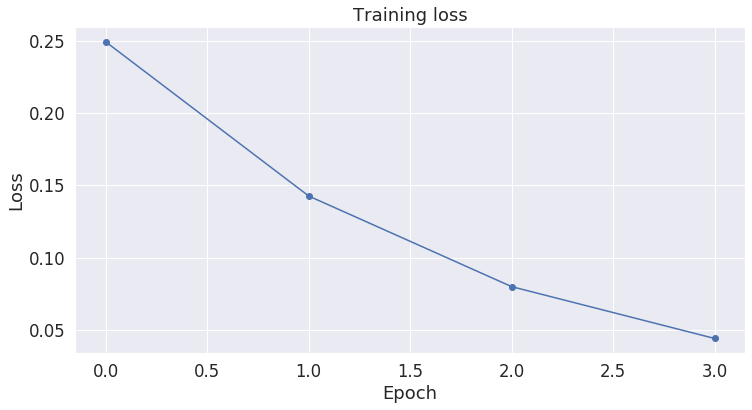

In [ ]:

import matplotlib.pyplot as plt
% matplotlib inline
import seaborn as sns

# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)


# Plot the learning curve.
plt.plot(loss_values, 'b-o')

# Label the plot.
plt.title("Training loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

In [ ]:
# Load the dataset into a pandas dataframe.
df1 = pd.read_csv("/content/drive/My Drive/MinorProject/eng_dev.csv")
df1=df1.drop(columns=['ID','Sub-task A'])

# Report the number of sentences.
print('Number of test sentences: {:,}\n'.format(df1.shape[0]))
df1['Sub-task B'] = df1['Sub-task B'].map({'GEN': 0, 'NGEN':1})
df1

Number of test sentences: 1,066



,Text,Sub-task B
0,U deserve more subscribers. U really great.,1
1,Nice video....,1
2,sorry if i bother somebody.. iam a defence asp...,0
3,Joker was amazing....it was not glamorised !.....,1
4,Nice baro,1
...,...,...
1061,Ranu Mandal is third class [woman.No](http://w...,1
1062,[15:23](https://www.youtube.com/watch?v=N_ZMfQ...,1
1063,Love u bro keep it up,1
1064,May I help you?,1


In [ ]:
df1=df1.rename(columns={"Sub-task B":"label"})


# Create sentence and label lists
sentences = df1.Text.values
labels = df1.label.values


In [ ]:
# Tokenize all of the sentences and map the tokens to thier word IDs.
input_ids = []
for sent in sentences:
   # `encode` will:
    #   (1) Tokenize the sentence.
    #   (2) Prepend the `[CLS]` token to the start.
    #   (3) Append the `[SEP]` token to the end.
    #   (4) Map tokens to their IDs.
    encoded_sent = tokenizer.encode(
                        sent,            # Sentence to encode.           
                        add_special_tokens = True,  # Add '[CLS]' and '[SEP]'
                                           )
    
    input_ids.append(encoded_sent)



# Pad our input tokens
input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, 
                          dtype="long", truncating="post", padding="post")
# Create attention masks
attention_masks = []


# Create a mask of 1s for each token followed by 0s for padding
for seq in input_ids:
  seq_mask = [float(i>0) for i in seq]
  attention_masks.append(seq_mask) 


# Convert to tensors.
prediction_inputs = torch.tensor(input_ids)
prediction_masks = torch.tensor(attention_masks)
prediction_labels = torch.tensor(labels)

# Set the batch size.
batch_size = 32  

# Create the DataLoader.
prediction_data = TensorDataset(prediction_inputs, prediction_masks, prediction_labels)
prediction_sampler = SequentialSampler(prediction_data)
prediction_dataloader = DataLoader(prediction_data, sampler=prediction_sampler, batch_size=batch_size)

Token indices sequence length is longer than the specified maximum sequence length for this model (576 > 512). Running this sequence through the model will result in indexing errors


In [ ]:
# Prediction on test set
print('Predicting labels for {:,} test sentences...'.format(len(prediction_inputs)))

# Put model in evaluation mode
model.eval()


# Tracking variables 
predictions , true_labels = [], []
for batch in prediction_dataloader:
  # Add batch to GPU
  batch = tuple(t.to(device) for t in batch)

  # Unpack the inputs from our dataloader
  b_input_ids, b_input_mask, b_labels = batch  

  # Telling the model not to compute or store gradients, saving memory and 
  # speeding up prediction
  with torch.no_grad():
    # Forward pass, calculate logit predictions
      outputs = model(b_input_ids, token_type_ids=None, 
                      attention_mask=b_input_mask)

  # Move logits and labels to CPU
  logits = outputs[0]
  logits = logits.detach().cpu().numpy()
  label_ids = b_labels.to('cpu').numpy()

  # Store predictions and true labels
  predictions.append(logits) 
  true_labels.append(label_ids)


Predicting labels for 1,066 test sentences...


In [ ]:
print('Positive samples: %d of %d (%.2f%%)' % (df.label.sum(), len(df.label), (df.label.sum() / len(df.label) * 100.0)))

Positive samples: 3954 of 4263 (92.75%)


In [ ]:
from sklearn.metrics import classification_report
clf_set = []
for i in range(len(true_labels)):
   # The predictions for this batch are a 2-column ndarray (one column for "0" 
  # and one column for "1"). Pick the label with the highest value and turn this
  # in to a list of 0s and 1s.
  pred_labels_i = np.argmax(predictions[i], axis=1).flatten()
  
  # Calculate and store the coef for this batch.  
  clf = classification_report(true_labels[i], pred_labels_i)                
  clf_set.append(clf)

Calculating Matthews Corr. Coef. for each batch...


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
# Combine the predictions for each batch into a single list of 0s and 1s.
flat_predictions = [item for sublist in predictions for item in sublist]
flat_predictions = np.argmax(flat_predictions, axis=1).flatten()


# Combine the correct labels for each batch into a single list.
flat_true_labels = [item for sublist in true_labels for item in sublist]
clf= classification_report(flat_true_labels, flat_predictions)
print(clf)

              precision    recall  f1-score   support

           0       0.54      0.38      0.45        73
           1       0.96      0.98      0.97       993

    accuracy                           0.94      1066
   macro avg       0.75      0.68      0.71      1066
weighted avg       0.93      0.94      0.93      1066

